In [30]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
n_samples,n_features = 100,3
train_x = torch.rand(n_samples, n_features)
train_y = torch.sin(train_x[:,0]) + torch.cos(train_x[:,1]) + torch.randn(train_x[:,2].size()) + math.sqrt(0.04)
# train_x = torch.linspace(0,1,50)
# train_y = torch.sin(train_x*(2*math.pi))+torch.randn(train_x.size()) + math.sqrt(0.04)

In [39]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=n_features))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)


model.train()
likelihood.train()
training_iter = 50
optimizer = torch.optim.Adam(model.parameters(),lr = 0.1)

#Loss for GPs
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output,train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscales: %s   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.detach().numpy(),  # Print all lengthscales
        model.likelihood.noise.item()
        ))
    optimizer.step()

Iter 1/50 - Loss: 1.654   lengthscales: [[0.6931472 0.6931472 0.6931472]]   noise: 0.693
Iter 2/50 - Loss: 1.625   lengthscales: [[0.6444014 0.7443966 0.7443966]]   noise: 0.744
Iter 3/50 - Loss: 1.603   lengthscales: [[0.6784954  0.79698735 0.79778415]]   noise: 0.798
Iter 4/50 - Loss: 1.585   lengthscales: [[0.69394493 0.8499995  0.8525442 ]]   noise: 0.852
Iter 5/50 - Loss: 1.572   lengthscales: [[0.68570316 0.90263295 0.90804654]]   noise: 0.907
Iter 6/50 - Loss: 1.563   lengthscales: [[0.6669975 0.9542861 0.9637566]]   noise: 0.962
Iter 7/50 - Loss: 1.556   lengthscales: [[0.64534223 1.0045618  1.0191902 ]]   noise: 1.016
Iter 8/50 - Loss: 1.552   lengthscales: [[0.62573344 1.0532285  1.0739145 ]]   noise: 1.068
Iter 9/50 - Loss: 1.549   lengthscales: [[0.6112491 1.1001639 1.127548 ]]   noise: 1.117
Iter 10/50 - Loss: 1.548   lengthscales: [[0.6026922 1.1453016 1.1797562]]   noise: 1.162
Iter 11/50 - Loss: 1.548   lengthscales: [[0.59914106 1.188594   1.2302526 ]]   noise: 1.204
I

In [40]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

test_x = torch.randn(20, n_features)
# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    
    observed_pred = likelihood(model(test_x))
    print(observed_pred.mean)  # Predicted means


tensor([1.6091, 1.6091, 1.0749, 1.6091, 1.6091, 1.6757, 1.6091, 1.6091, 1.6091,
        1.6091, 1.6091, 1.6673, 1.6090, 1.6091, 1.5767, 1.6091, 1.6091, 1.6091,
        1.6091, 1.6091])


In [41]:
# with torch.no_grad():
#     # Initialize plot
#     f, ax = plt.subplots(1, 1, figsize=(10, 10))

#     # Get upper and lower confidence bounds
#     lower, upper = observed_pred.confidence_region()
#     # Plot training data as black stars
#     ax.plot(train_x.numpy(), train_y.numpy(), 'kx')

#     # ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
#     # Plot predictive means as blue line
#     ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
#     # Shade between the lower and upper confidence bounds
#     ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
#     ax.set_ylim([-3, 3])
#     ax.legend(['Observed Data', 'Mean', 'Confidence'])


Setup Training Data

In [42]:
# Generate test data
n_features = train_x.size(1)  # Number of features in train_x
test_x = torch.rand(50, n_features)  # Shape: (50, n_features)
test_y = torch.sin(test_x[:, 0]) + torch.cos(test_x[:, 1]) + torch.randn(test_x[:,2].size()) + math.sqrt(0.04)  # True function for comparison


In [43]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))  # Predictive distribution
    pred_mean = observed_pred.mean  # Predicted means
    pred_var = observed_pred.variance  # Predictive variances
    pred_conf = observed_pred.confidence_region()  # 2 std deviation confidence region


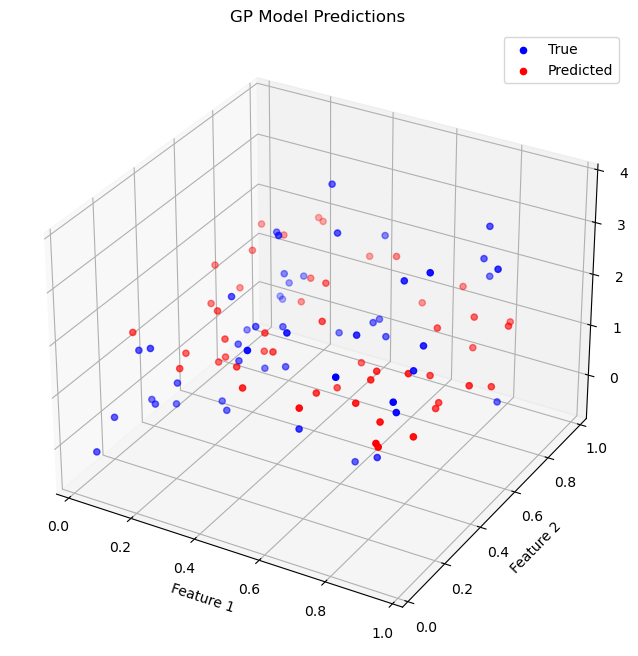

In [48]:
from mpl_toolkits.mplot3d import Axes3D

# Example for 3D data (three features)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot true values
ax.scatter(test_x[:, 0], test_x[:, 2], test_y, label='True', color='blue')

# Plot predicted mean
ax.scatter(test_x[:, 1], test_x[:, 2], pred_mean, label='Predicted', color='red')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Output')
ax.set_title('GP Model Predictions')
plt.legend()
plt.show()
